Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

In [1]:
import tensorflow as tf
import platform
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool2D
from tensorflow.keras.optimizers import Adam

print(f'Python Platform: {platform.platform()}')
print(f'Tensorflow Version: {tf.__version__}')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print('GPU is', 'available' if gpu else 'NOT AVAILABLE')
# tf.keras.backend.set_floatx('float32')

2023-09-06 19:40:37.197202: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 19:40:37.208363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 19:40:37.311274: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 19:40:37.312534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 19:40:38.139323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Python Platform: Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Tensorflow Version: 2.13.0
GPU is NOT AVAILABLE


2023-09-06 19:40:39.096460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 19:40:39.096816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
# Dataset is a continuous recording of movements at 20Hz

file = open('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
data = pd.DataFrame(data = processedList, columns = columns)
print(data.head(), '\n')
print(data.info(), '\n')
print(data['activity'].value_counts())

  user activity            time            x          y            z
0   33  Jogging  49105962326000   -0.6946377  12.680544   0.50395286
1   33  Jogging  49106062271000     5.012288  11.264028   0.95342433
2   33  Jogging  49106112167000     4.903325  10.882658  -0.08172209
3   33  Jogging  49106222305000  -0.61291564  18.496431    3.0237172
4   33  Jogging  49106332290000   -1.1849703  12.108489     7.205164 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB
None 

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599


In [5]:
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


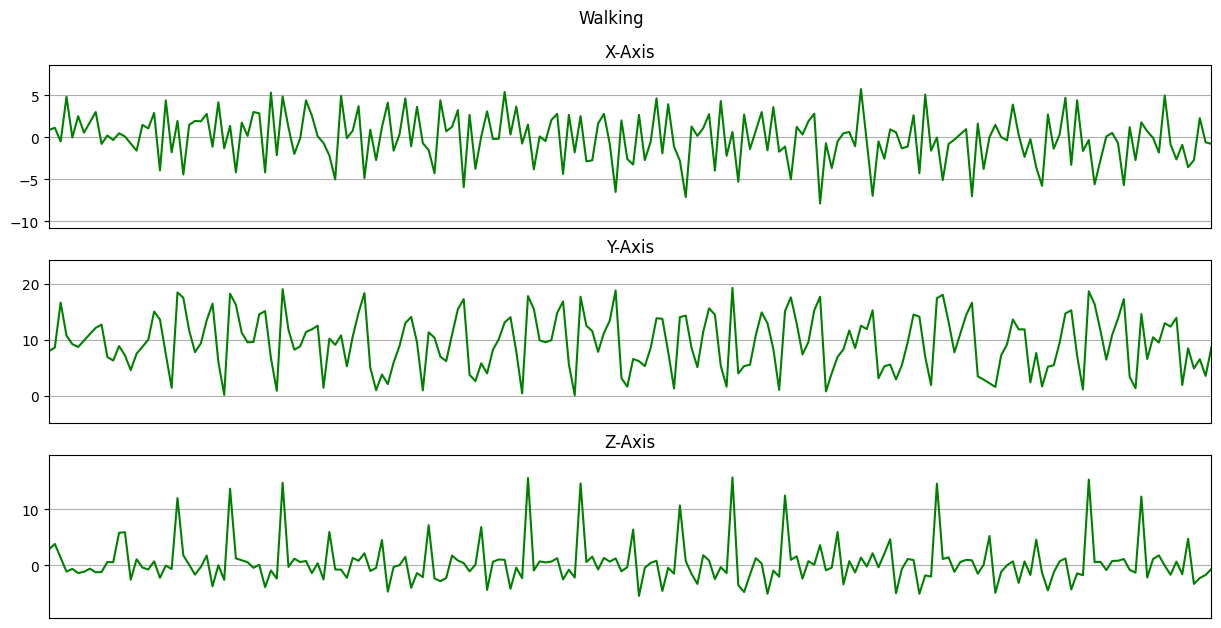

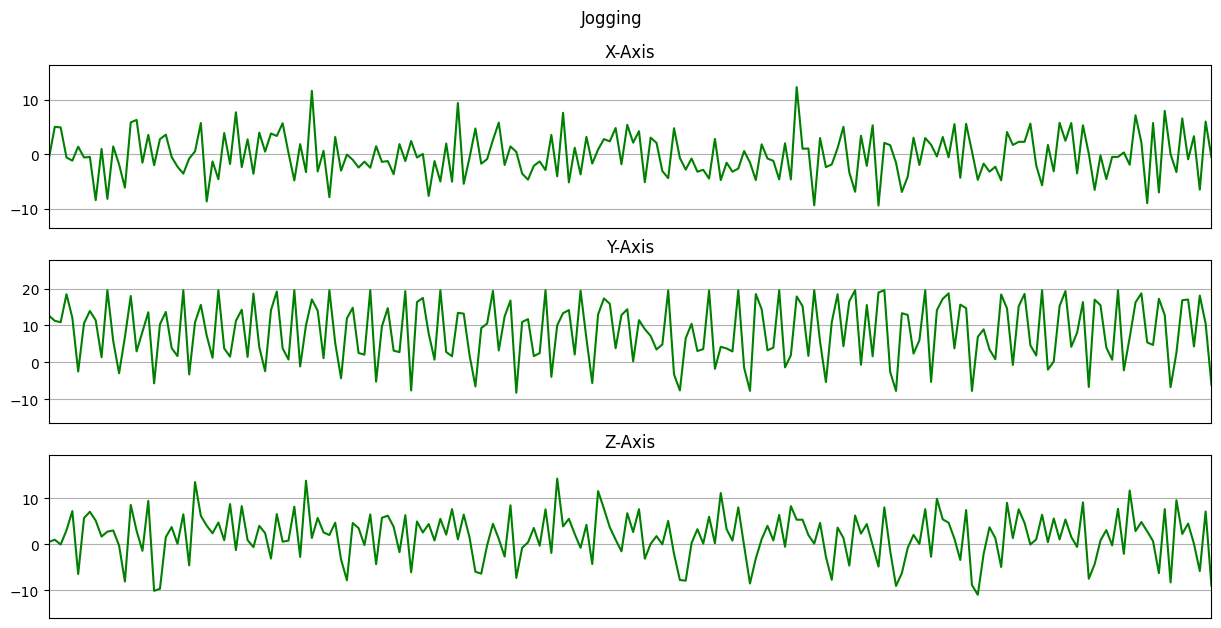

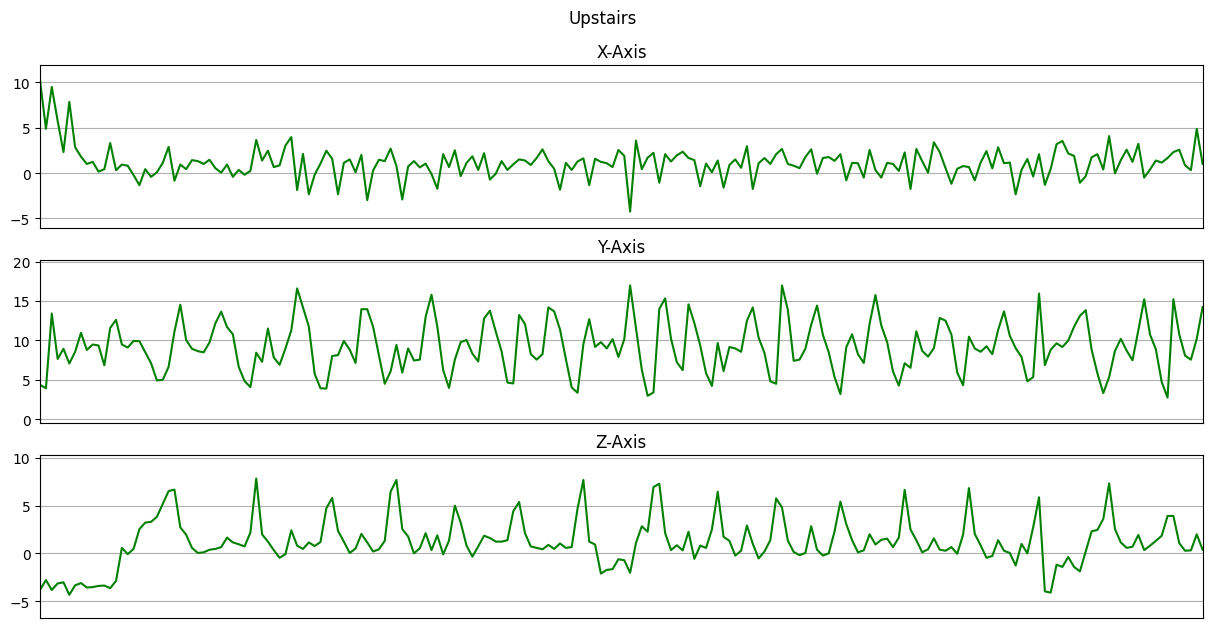

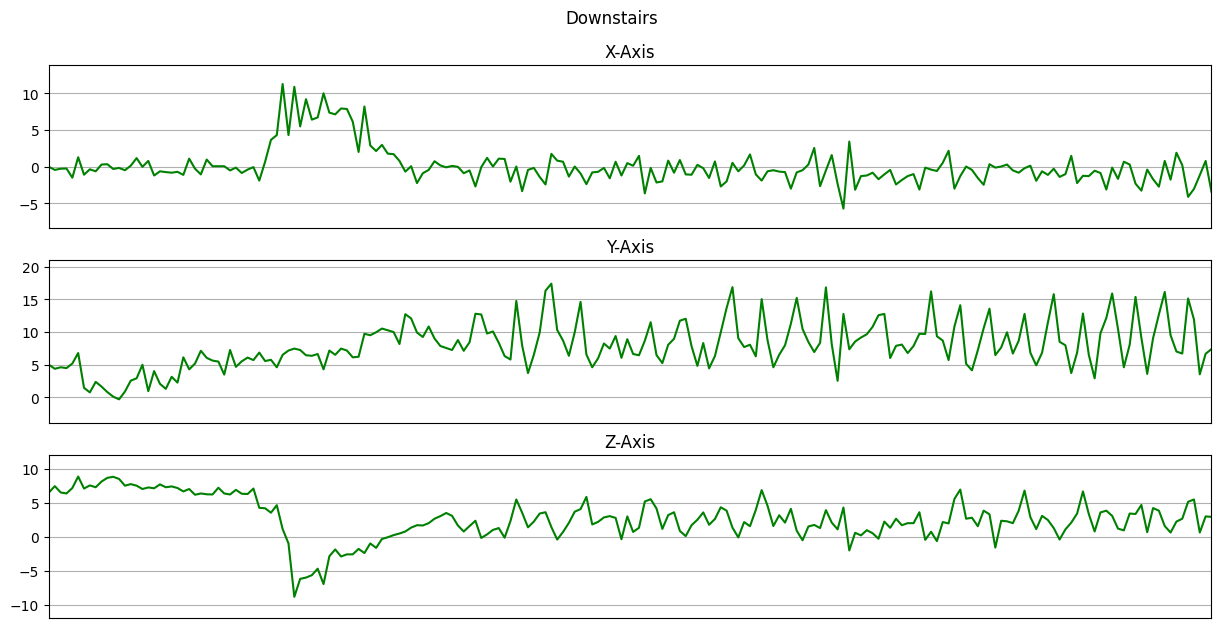

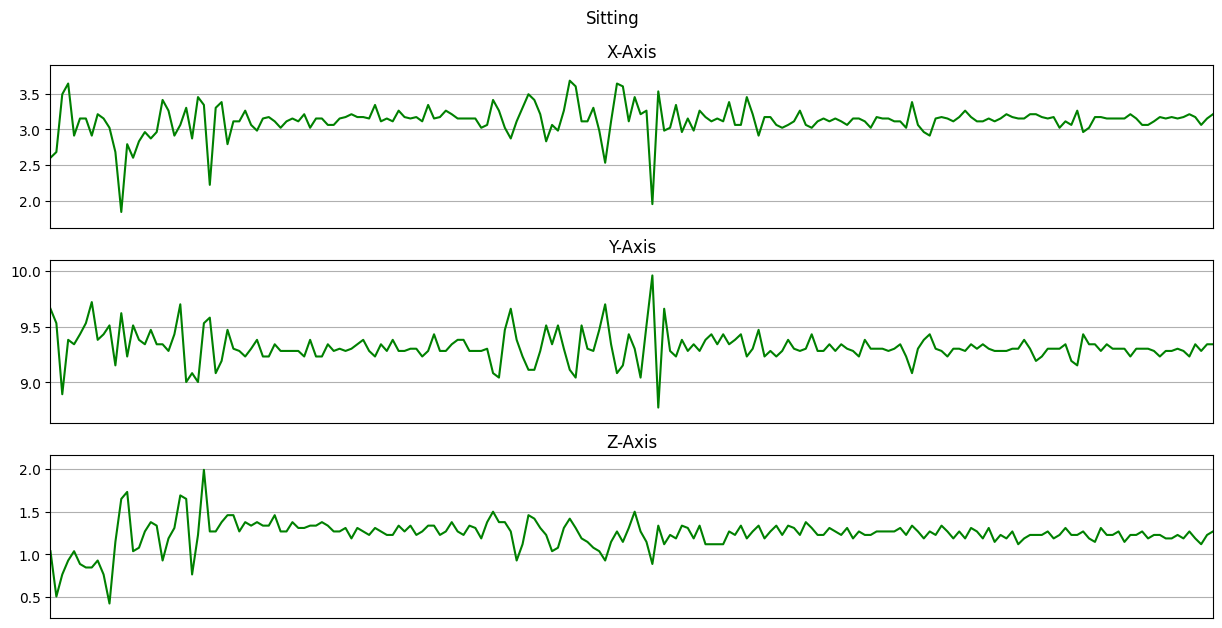

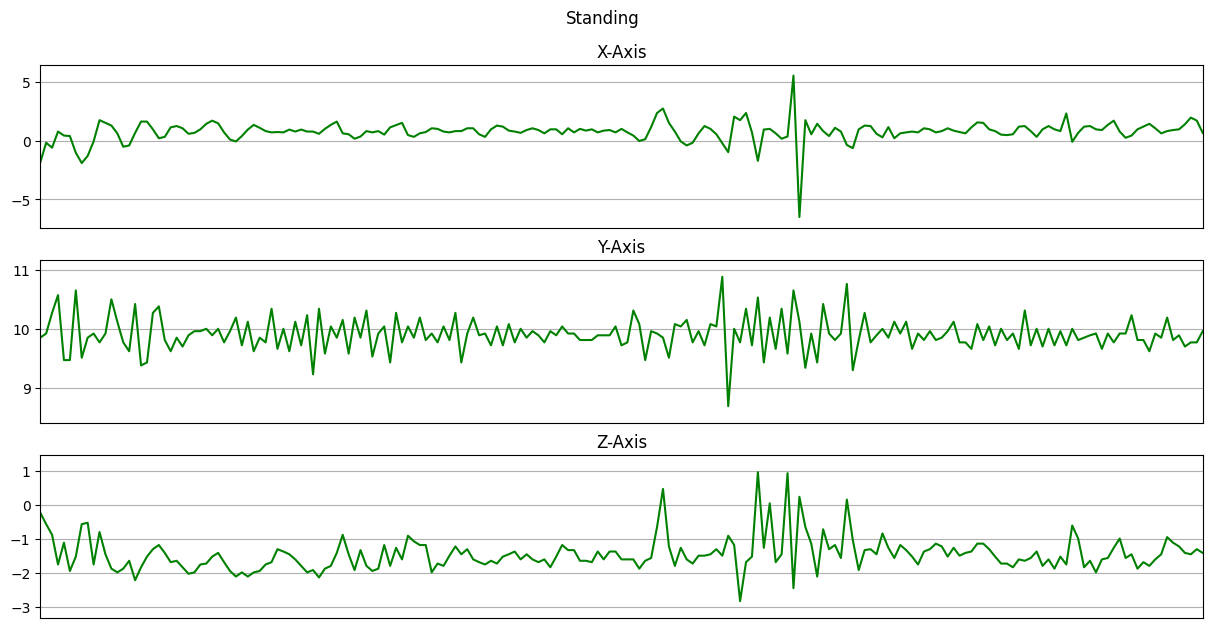

In [6]:
# Fs is frames/sec

Fs = 20
activities = data['activity'].value_counts().index

def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [7]:
# Standing has least entries, balance data

df = data.drop(['user', 'time'], axis = 1).copy()

Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()

balanced_data = pd.DataFrame()
balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data['activity'].value_counts()

activity
Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: count, dtype: int64

In [8]:
# Add answer label

label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [9]:
from scipy.stats import zscore
from scipy import signal

# Extract label

X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

numeric_cols = X.select_dtypes(include=[np.number]).columns
mod_df = X[numeric_cols].apply(signal.detrend)
mod_df = mod_df[numeric_cols].apply(zscore)
X.drop(labels=numeric_cols, axis='columns', inplace=True)
X[numeric_cols] = mod_df[numeric_cols]

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head()

/tmp/ipykernel_223682/298898933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(labels=numeric_cols, axis='columns', inplace=True)
/tmp/ipykernel_223682/298898933.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_cols] = mod_df[numeric_cols]
/tmp/ipykernel_223682/298898933.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,x,y,z,label
597,-0.341665,-0.380227,0.717771,5
598,-0.267134,-0.259075,1.019993,5
599,-0.710372,1.329045,0.266386,5
600,0.738670,0.163572,-0.491362,5
601,-0.583659,-0.137871,-0.342338,5


In [10]:
# Partition data into frames

import scipy.stats as stats

Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

#   X is the dataset in 3 dimensions:
#       532 is the number of datapoints
#       80 is the number of slices per datapoint
#       3 represnts the x, y and z values
#   y are the labels for each datapoint in X
X.shape, y.shape

((532, 80, 3), (532,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)

X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [12]:
# test model
# model = Sequential()
# model.add(Conv1D(16, 3, activation='relu', input_shape=(1, 40, 12)))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(6, activation='softmax'))
# 
# model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# model.summary()

In [13]:
model = Sequential()
#model.add(tf.keras.layers.Reshape((80, 3)))
model.add(tf.keras.layers.Input(shape=(80, 3)))
model.add(Conv1D(16, 3, activation='relu', input_shape=X_train[0]))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(6, activation='softmax'))
model.build((1,80,3))
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 16)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 74, 32)            2592      
                                                                 
 flatten (Flatten)           (None, 2368)              0         
                                                                 
 dense (Dense)               (None, 64)                151616    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 154758 (604.52 KB)
Trainable params: 15475

In [14]:
num_epochs = 10
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
14/14 [==============================] - 1s 15ms/step - loss: 1.5636 - accuracy: 0.3812 - val_loss: 1.1528 - val_accuracy: 0.6542
Epoch 2/10
14/14 [==============================] - 0s 6ms/step - loss: 1.0059 - accuracy: 0.6471 - val_loss: 0.6822 - val_accuracy: 0.7570
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: 0.7540 - accuracy: 0.7153 - val_loss: 0.4628 - val_accuracy: 0.8692
Epoch 4/10
14/14 [==============================] - 0s 6ms/step - loss: 0.4879 - accuracy: 0.8282 - val_loss: 0.3124 - val_accuracy: 0.9065
Epoch 5/10
14/14 [==============================] - 0s 7ms/step - loss: 0.3754 - accuracy: 0.8729 - val_loss: 0.2912 - val_accuracy: 0.9346
Epoch 6/10
14/14 [==============================] - 0s 6ms/step - loss: 0.3132 - accuracy: 0.8871 - val_loss: 0.2808 - val_accuracy: 0.8785
Epoch 7/10
14/14 [==============================] - 0s 6ms/step - loss: 0.2609 - accuracy: 0.9294 - val_loss: 0.2561 - val_accuracy: 0.9346
Epoch 8/10
14/14 [=

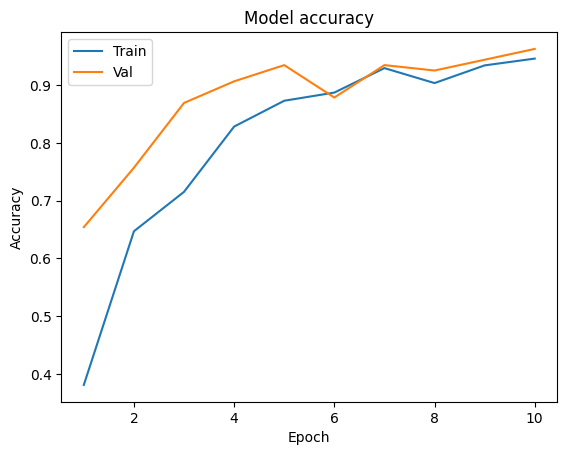

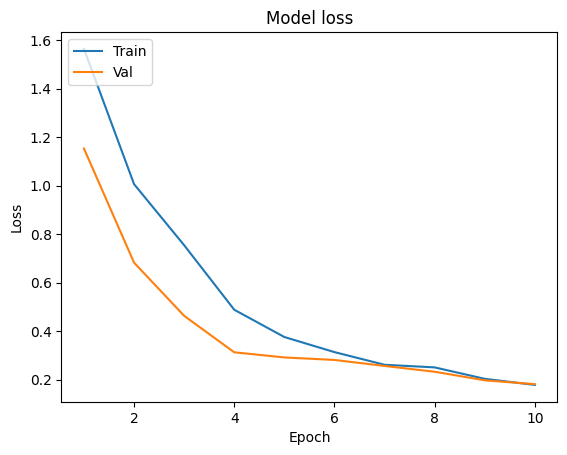

In [15]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history,num_epochs)

4/4 [==============================] - 0s 3ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

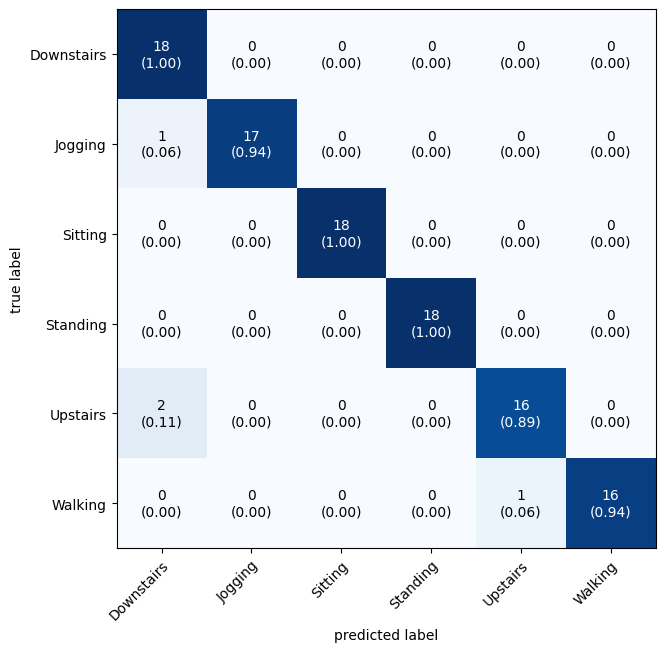

In [16]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# predict_classes generates class predictions for the input samples.

y_pred = model.predict(X_test)
y_classes = np.argmax(y_pred,axis=1)

mat = confusion_matrix(y_test, y_classes)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [17]:
# Save model
import os, sys

# The weights are arranged in such a way that: 
#   weights[x] contains data for each column in each filter
#   weights[][y] contains data for each row in each filter
#   weights[][][z] indexes each filter
# So weights[8][4][0] references the 8th column and 4th row of the 0th filter.

# First Conv1D weights
cfd = sys.path[0]
conv1_w = open(os.path.join(cfd, 'CNN/conv1_weights.txt'), "w")
tensor = model.layers[0].get_weights()[0]

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        for k in range(len(tensor[0][0])):
            conv1_w.write(str(tensor[i][j][k]))
            if i < len(tensor) - 1 or j < len(tensor[0]) - 1 or k < len(tensor[0][0]) - 1:
                conv1_w.write(',')

conv1_w.close()

# First Conv1D biases
conv1_b = open(os.path.join(cfd, 'CNN/conv1_biases.txt'), "w")
biases = model.layers[0].get_weights()[1]
conv1_b.write(",".join(str(x) for x in biases))
conv1_b.close()

# Second Conv1D weights
cfd = sys.path[0]
conv2_w = open(os.path.join(cfd, 'CNN/conv2_weights.txt'), "w")
tensor = model.layers[1].get_weights()[0]

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        for k in range(len(tensor[0][0])):
            conv2_w.write(str(tensor[i][j][k]))
            if i < len(tensor) - 1 or j < len(tensor[0]) - 1 or k < len(tensor[0][0]) - 1:
                conv2_w.write(',')

conv2_w.close()

# Second Conv1D biases
conv2_b = open(os.path.join(cfd, 'CNN/conv2_biases.txt'), "w")
biases = model.layers[1].get_weights()[1]
conv2_b.write(",".join(str(x) for x in biases))
conv2_b.close()

# First dense layer weights
tensor = model.layers[3].get_weights()[0]

dense1_w = open(os.path.join(cfd, 'CNN/dense1_weights.txt'), "w")

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        dense1_w.write(str(tensor[i][j]))
        if i < len(tensor) - 1 or j < len(tensor[0]) - 1:
            dense1_w.write(',')

dense1_w.close()

# First dense layer biases
dense1_b = open(os.path.join(cfd, 'CNN/dense1_biases.txt'), "w")
biases = model.layers[3].get_weights()[1]
dense1_b.write(",".join(str(x) for x in biases))
dense1_b.close()

# Second dense layer weights
tensor = model.layers[5].get_weights()[0]

dense2_w = open(os.path.join(cfd, 'CNN/dense2_weights.txt'), "w")

for i in range(len(tensor)):
    for j in range(len(tensor[0])):
        dense2_w.write(str(tensor[i][j]))
        if i < len(tensor) - 1 or j < len(tensor[0]) - 1:
            dense2_w.write(',')

dense2_w.close()

# Second dense layer biases
dense2_b = open(os.path.join(cfd, 'CNN/dense2_biases.txt'), "w")
biases = model.layers[5].get_weights()[1]
dense2_b.write(",".join(str(x) for x in biases))
dense2_b.close()

In [18]:
# Test against C++
import subprocess

#test_result = subprocess.run([out_loc, '<', test_loc], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
test_loc = os.path.join(cfd, 'CNN/test.in')
out_loc = os.path.join(cfd, 'CNN/a.out')

total_tests = 2000
total_correct = 0

test_list = []
cpp_answer = []

for i in range(total_tests):
    choice = np.random.randint(0, len(X))
    test_list.append(X[choice])
    
    Xflat = X[choice].flatten()
    np.savetxt(test_loc, Xflat)

    test_pipe = subprocess.Popen(['cat', test_loc], stdout=subprocess.PIPE)
    out_pipe = subprocess.Popen([out_loc], stdin=test_pipe.stdout, stdout=subprocess.PIPE)
    output = out_pipe.communicate()[0].decode('ascii')
    cpp_answer.append(int(output))

prediction = model.predict(tf.reshape(test_list, [total_tests, 80, 3]))

for i in range(total_tests):
    if cpp_answer[i] == np.argmax(prediction[i]):
        total_correct += 1
    else:
        print('Mismatch:', np.argmax(prediction[i]), 'vs', cpp_answer[i])

print('Total tests: ', total_tests)
print('Total correct: ', total_correct)
print('% correct: ', total_correct / total_tests)

63/63 [==============================] - 0s 2ms/step
Mismatch: 1 vs 4
Mismatch: 1 vs 4
Mismatch: 0 vs 4
Mismatch: 4 vs 0
Mismatch: 1 vs 5
Mismatch: 1 vs 4
Mismatch: 4 vs 0
Mismatch: 1 vs 5
Mismatch: 1 vs 4
Mismatch: 1 vs 4
Mismatch: 0 vs 4
Mismatch: 5 vs 1
Mismatch: 1 vs 4
Mismatch: 0 vs 4
Mismatch: 5 vs 1
Mismatch: 0 vs 4
Mismatch: 5 vs 1
Mismatch: 4 vs 0
Mismatch: 1 vs 4
Mismatch: 1 vs 5
Mismatch: 5 vs 1
Mismatch: 1 vs 5
Mismatch: 1 vs 4
Mismatch: 1 vs 4
Mismatch: 1 vs 5
Mismatch: 1 vs 4
Mismatch: 0 vs 4
Mismatch: 5 vs 1
Mismatch: 0 vs 4
Mismatch: 5 vs 1
Mismatch: 1 vs 5
Mismatch: 1 vs 4
Total tests:  2000
Total correct:  1968
% correct:  0.984
